In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

In [2]:
results_path = '~/sims_n_results/nucmoles_opusupdate_aug2019/'
tamuNoRatio_path = results_path + 'tamuNoRatio/'
tamuRatio_path = results_path + 'tamuRatio/'
sfco_path = results_path + 'sfco/'
# Copied from scripts
uncs = [0.05, 0.1, 0.15, 0.2]
job_dirs = ['Job' + str(i) + '_unc' + str(unc) for i, unc in enumerate(uncs)]

In [3]:
dfs = {}
for i, unc_job in enumerate(job_dirs):
    dfs['dfTamu' + str(i)] = pd.read_csv(tamuNoRatio_path + unc_job + '/' + unc_job + '.csv')
    dfs['dfTamuRatio' + str(i)] = pd.read_csv(tamuRatio_path + unc_job + '/' + unc_job + '.csv')
    dfs['dfSfco' + str(i)] = pd.read_csv(sfco_path + unc_job + '/' + unc_job + '.csv')
# for ease of testing things
df0 = dfs['dfTamu0']
df2 = dfs['dfSfco2']

In [4]:
dfs.keys()

dict_keys(['dfTamu0', 'dfTamuRatio0', 'dfSfco0', 'dfTamu1', 'dfTamuRatio1', 'dfSfco1', 'dfTamu2', 'dfTamuRatio2', 'dfSfco2', 'dfTamu3', 'dfTamuRatio3', 'dfSfco3'])

In [5]:
dfs['dfSfco1'].columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'sim_idx', 'ReactorType', 'CoolingTime',
       'Enrichment', 'Burnup', 'OrigenReactor', 'pred_idx', 'pred_ReactorType',
       'pred_CoolingTime', 'pred_Enrichment', 'pred_Burnup',
       'pred_OrigenReactor', 'MaxLogLL', 'MaxLLUnc', '2ndMaxLogLL',
       '2ndMaxLLUnc', 'CDF_LogLL_0.9998', 'CDF_LLUnc_0.9998',
       'CDF_LogLL_0.9988', 'CDF_LLUnc_0.9988', 'CDF_LogLL_0.95',
       'CDF_LLUnc_0.95', 'CDF_LogLL_0.9', 'CDF_LLUnc_0.9', 'CDF_LogLL_0.5',
       'CDF_LLUnc_0.5', 'CDF_LogLL_0.1', 'CDF_LLUnc_0.1', 'CDF_LogLL_0.01',
       'CDF_LLUnc_0.01', 'ReactorType_Score', 'CoolingTime_Error',
       'Enrichment_Error', 'Burnup_Error', 'OrigenReactor_Score'],
      dtype='object')

In [6]:
max_ll_pred = df0['MaxLogLL'].quantile(1, interpolation='higher')
df0.loc[df0['MaxLogLL'] == max_ll_pred].index

Int64Index([23922], dtype='int64')

# MLL Heatmap

In [8]:
def plot_heatmap(i, dfname):
    df = dfs['df' + dfname + str(i)]
    
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    vmin = 0
    vmax = df['MaxLogLL'].quantile(1, interpolation='higher')
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    
    x = df['Burnup']
    y = df['CoolingTime']#['Enrichment']
    triang = tri.Triangulation(x, y)
    z = df['MaxLogLL']
    
    surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')
    
    ax.set_title(str(int(uncs[i]*100)) + '% Uncertainty', fontsize=20, pad=15)
    ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
    ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
    
    cbar = fig.colorbar(surf)
    cbar.ax.set_ylabel('LogLikelihood', size=20, labelpad=15)
    ax.tick_params(labelsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.show()
    
    dftitle = {'Tamu': 'tamuNoRatio', 'TamuRatio': 'tamuRatio', 'Sfco' : 'sfco'}
    fig.savefig('../plots/mll_heatmap_' + dftitle[dfname] + str(i) + '_unc' + str(uncs[i]) + '.png', bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

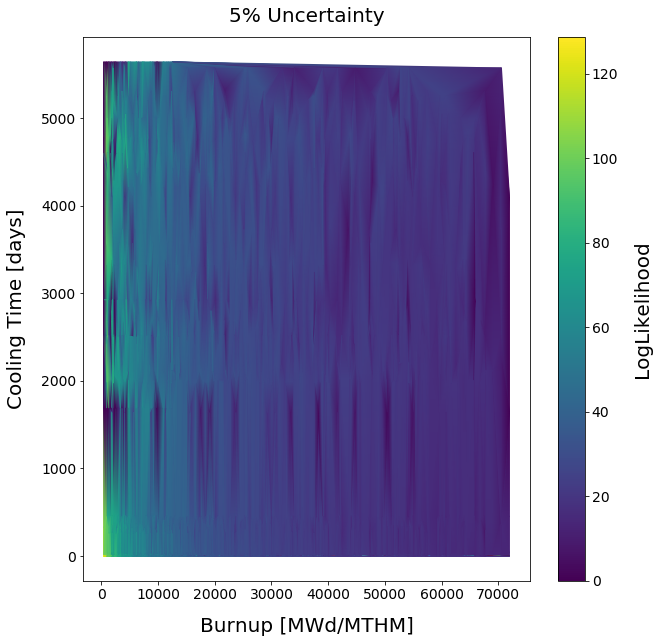

<Figure size 432x288 with 0 Axes>

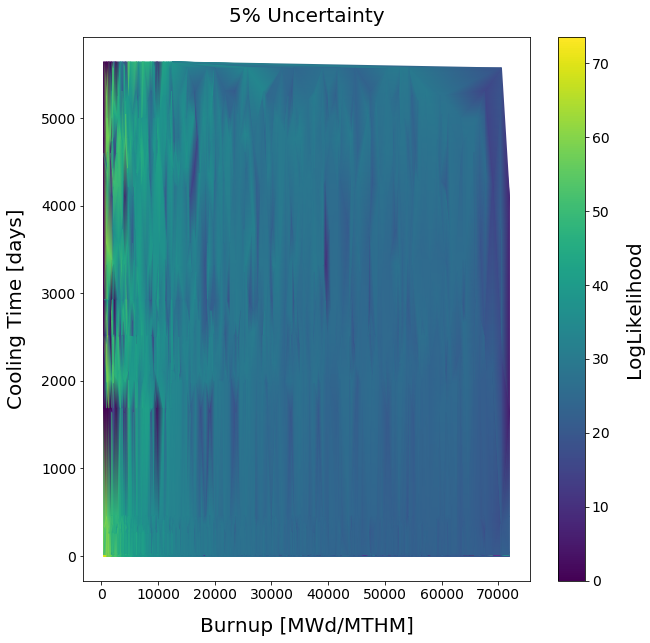

<Figure size 432x288 with 0 Axes>

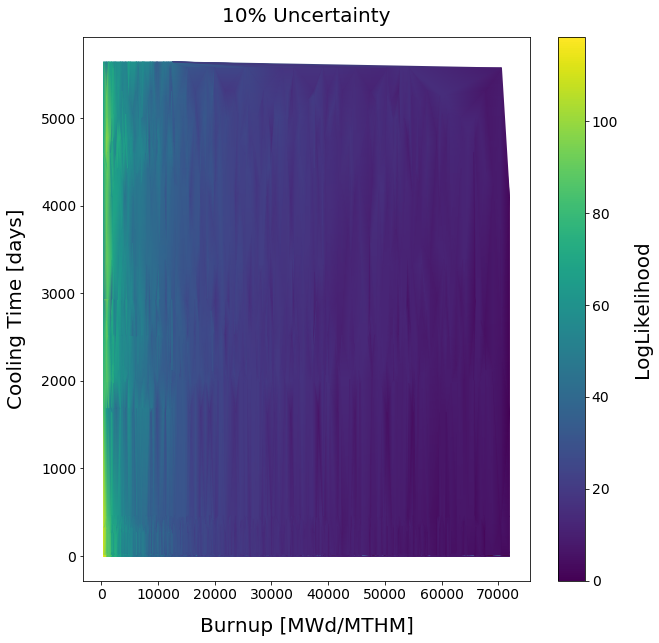

<Figure size 432x288 with 0 Axes>

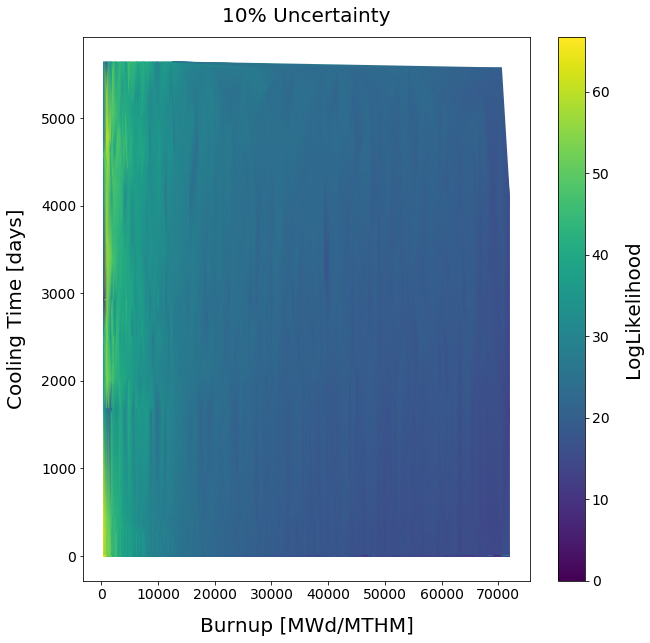

<Figure size 432x288 with 0 Axes>

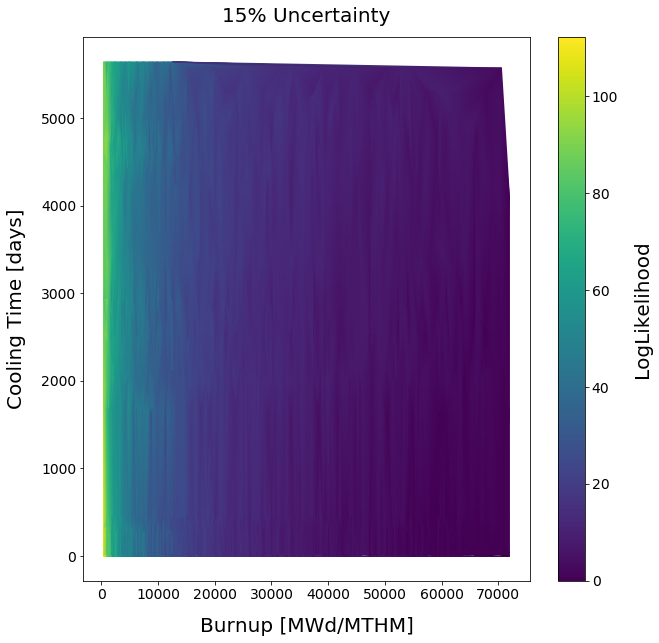

<Figure size 432x288 with 0 Axes>

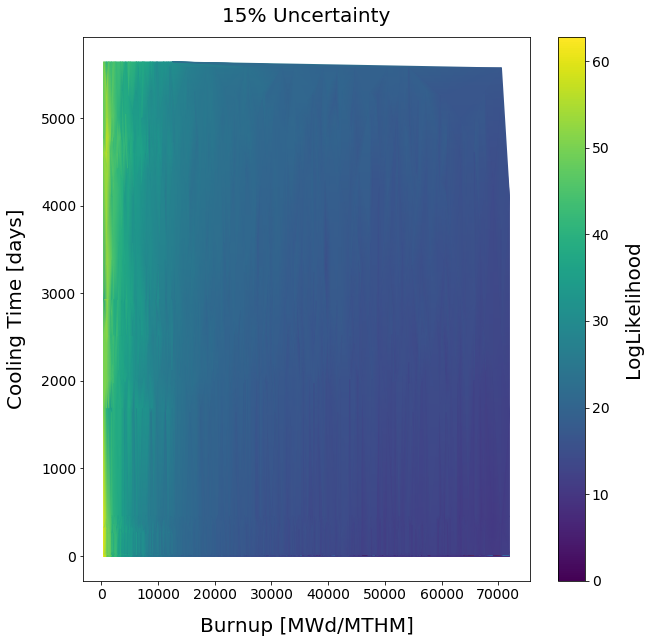

<Figure size 432x288 with 0 Axes>

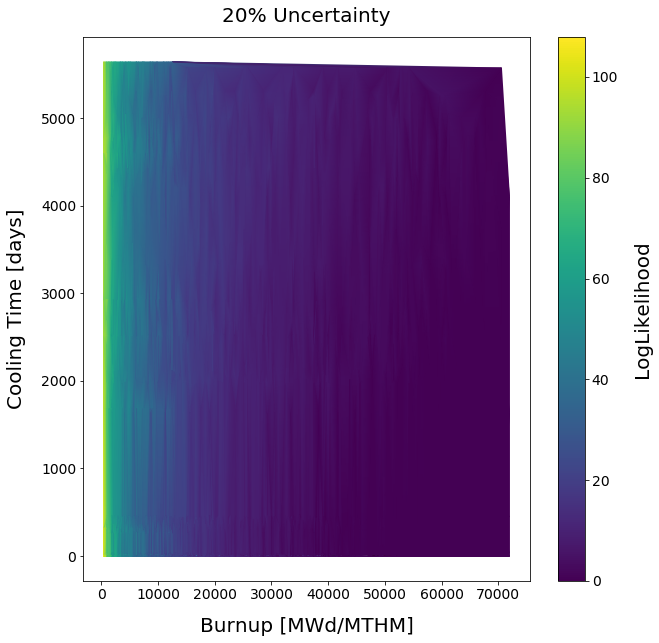

<Figure size 432x288 with 0 Axes>

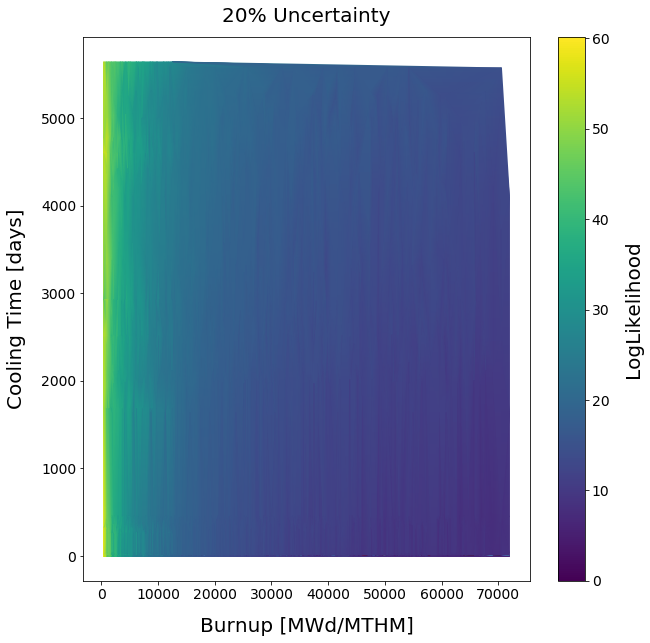

In [9]:
#plot_heatmap(0, 'Tamu')
for i in range(0, 4):
    plot_heatmap(i, 'Tamu')
    plot_heatmap(i, 'TamuRatio')
    #plot_heatmap(i, 'Sfco')

# MaxLL - 2ndMaxLL Heatmap

In [20]:
for dfname in list(dfs.keys()):
    df = dfs[dfname]
    df['AdjDiff'] = df['MaxLogLL'] - df['2ndMaxLogLL']

In [37]:
def plot_2ndheatmap(i, dfname):
    df = dfs['df' + dfname + str(i)]
    
    plt.clf()
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    
    vmin = 0
    vmax = 3#df['AdjDiff'].max()
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    
    x = df['Burnup']
    y = df['Enrichment']#['CoolingTime']#
    triang = tri.Triangulation(x, y)
    z = df['AdjDiff']
    
    surf = ax.tripcolor(triang, z, norm=norm, cmap=cm.viridis, shading='gouraud')
    
    ax.set_title(str(int(uncs[i]*100)) + '% Uncertainty', fontsize=20, pad=15)
    ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
    #ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
    ax.set_ylabel('Enrichment [U235%]', fontsize=20, labelpad=15)
    
    cbar = fig.colorbar(surf)
    cbar.ax.set_ylabel('Max LL - Adjacent LL', size=20, labelpad=15)
    ax.tick_params(labelsize=14)
    cbar.ax.tick_params(labelsize=14)
    plt.show()
    
    dftitle = {'Tamu': 'tamuNoRatio', 'TamuRatio': 'tamuRatio', 'Sfco' : 'sfco'}
    #fig.savefig('../plots/adj_mll_heatmap' + dftitle[dfname] + str(i) + '_unc' + str(uncs[i]) + '.png', bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

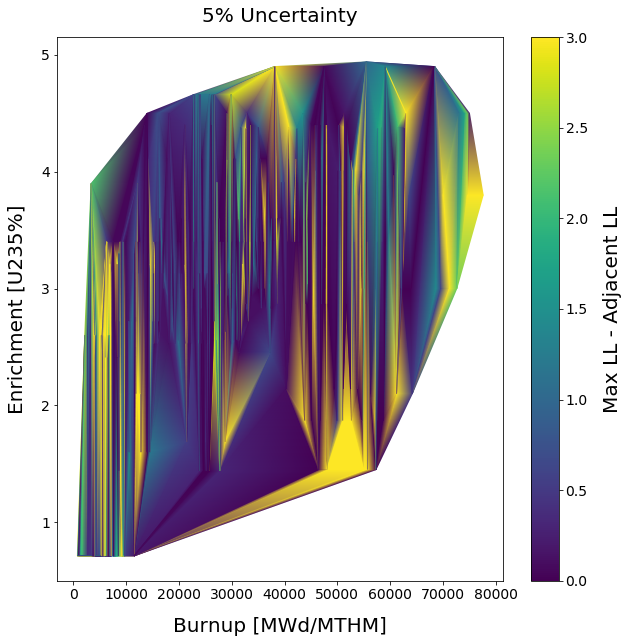

<Figure size 432x288 with 0 Axes>

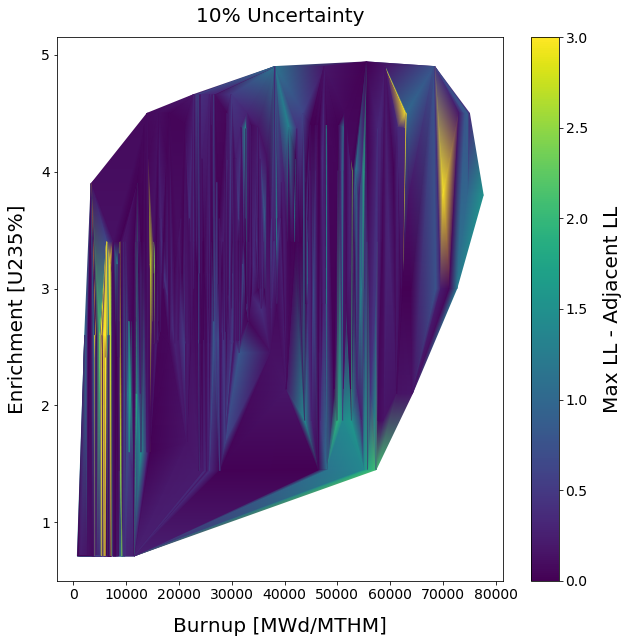

<Figure size 432x288 with 0 Axes>

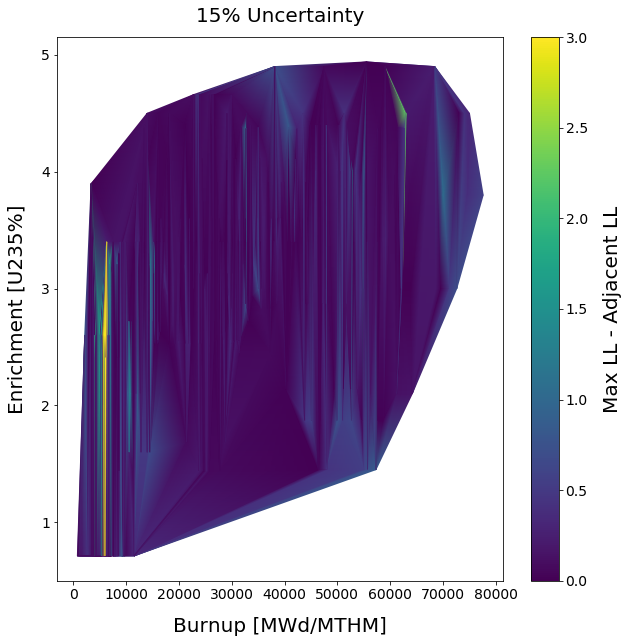

<Figure size 432x288 with 0 Axes>

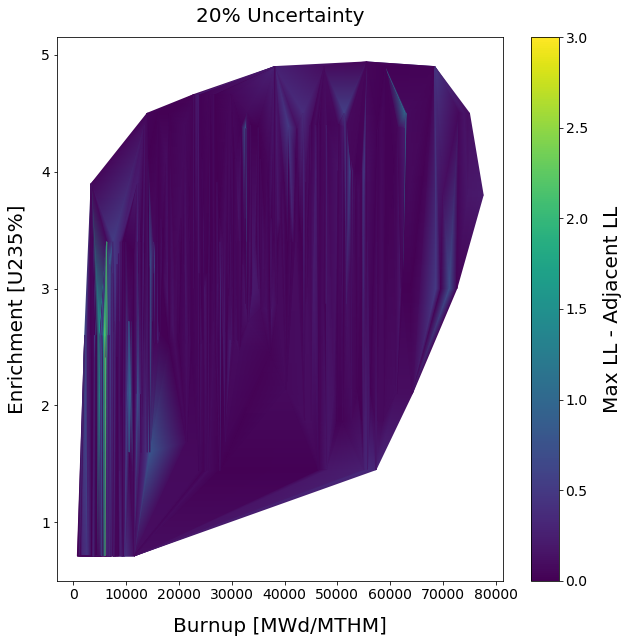

In [38]:
#plot_2ndheatmap(0, 'Tamu')
for i in range(0, 4):
#    plot_2ndheatmap(i, 'Tamu')
#    plot_2ndheatmap(i, 'TamuRatio')
    plot_2ndheatmap(i, 'Sfco')

# CDFs of select predictions

In [6]:
colors = {'DBrwn' : '#8c510a', 'MBrwn' : '#d8b365', 'LBrwn' : '#f6e8c3',
          'DTeal' : '#01665e', 'MTeal' : '#5ab4ac', 'LTeal' : '#c7eae5',
          'DPurp' : '#762a83', 'MPurp' : '#af8dc3', 'LPurp' : '#e7d4e8'
         }

In [7]:
maxLL = df0['MaxLogLL'].max()#quantile(1, interpolation='higher')
df0.loc[df0['MaxLogLL'] == maxLL]

,Unnamed: 0,Unnamed: 0.1,sim_idx,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,pred_idx,pred_ReactorType,...,CDF_LLUnc_0.5,CDF_LogLL_0.1,CDF_LLUnc_0.1,CDF_LogLL_0.01,CDF_LLUnc_0.01,ReactorType_Score,CoolingTime_Error,Enrichment_Error,Burnup_Error,OrigenReactor_Score
23922,12,12,23922,phwr,0.000656,0.711,407.77,candu19,23930,phwr,...,74.905834,-2832.186766,72.006507,-2866.203939,61.008878,True,0.000656,0.0,0.0,True


In [8]:
CDF_percentiles = [0.9998, 0.9988, 0.95, 0.9, 0.5, 0.1, 0.01]
CDF_names = ['CDF_LogLL_' + str(x) for x in CDF_percentiles]

In [9]:
df0['2ndMaxLogLL'].iloc[23923]

126.86803448087757

In [10]:
idx = 23923
maxLL = df0['MaxLogLL'].iloc[idx]
cdf0 = [maxLL, df0['2ndMaxLogLL'].iloc[idx]] + [df0[name].iloc[idx] for name in CDF_names]
cdf0 = [np.abs(x - maxLL) for x in cdf0]
cdf0

[0.0,
 0.9508790463098364,
 102.454537142064,
 1537.2586436519573,
 2369.2372973249753,
 2621.292357805709,
 2885.0412961724132,
 2953.5235378502066,
 2988.418228844712]

In [11]:
len(df0)

24678

In [56]:
def plot_cdfs(idx, dfname, ll_percentile):

    df0 = dfs['df' + dfname + '0']
    df1 = dfs['df' + dfname + '1']
    df2 = dfs['df' + dfname + '2']
    df3 = dfs['df' + dfname + '3']
    
    cdf0 = [df0['MaxLogLL'].iloc[idx]] + [df0[name].iloc[idx] for name in CDF_names]#, df0['2ndMaxLogLL'].iloc[idx]
    cdf1 = [df1['MaxLogLL'].iloc[idx]] + [df1[name].iloc[idx] for name in CDF_names]#, df1['2ndMaxLogLL'].iloc[idx]
    cdf2 = [df2['MaxLogLL'].iloc[idx]] + [df2[name].iloc[idx] for name in CDF_names]#, df2['2ndMaxLogLL'].iloc[idx]
    cdf3 = [df3['MaxLogLL'].iloc[idx]] + [df3[name].iloc[idx] for name in CDF_names]#, df3['2ndMaxLogLL'].iloc[idx]
    
    #max2_quantile = (len(df0) - 1) / len(df0)
    y = [1] + CDF_percentiles#, max2_quantile
    x0 = [(x - df0['MaxLogLL'].iloc[idx]) for x in cdf0]
    x1 = [(x - df1['MaxLogLL'].iloc[idx]) for x in cdf1]
    x2 = [(x - df2['MaxLogLL'].iloc[idx]) for x in cdf2]
    x3 = [(x - df3['MaxLogLL'].iloc[idx]) for x in cdf3]
    
    plt.clf()
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    
    ax.plot(x0, y, 'o-', color=colors['MBrwn'], mew=0, ms=5, label="5% Uncertainty")
    ax.plot(x1, y, 'o-', color=colors['MTeal'], mew=0, ms=5, label="10% Uncertainty")
    ax.plot(x2, y, 'o-', color=colors['MPurp'], mew=0, ms=5, label="15% Uncertainty")
    ax.plot(x3, y, 'o-', color=colors['DBrwn'], mew=0, ms=5, label="20% Uncertainty")
    
    ax.set_xlabel('LL - Max LL', fontsize=20, labelpad=15)
    ax.set_ylabel('CDF', fontsize=20, labelpad=15)
    ax.set_xlim(-3100, 90)
    
    ax.tick_params(labelsize=14)
    ax.legend(loc='best')#'right', bbox_to_anchor=(1.4, 0.5))
    
    title_str = 'CDF for prediction of idx ' + str(idx)
    subtitle_str = 'Max LL percentile wrt entire DB of preds: ' + str(ll_percentile * 100)
    plt.suptitle(title_str, y=1.01, fontsize=20)
    plt.title(subtitle_str, fontsize=15, pad=15)
    plt.show()
    
    fig.savefig('../plots/cdf_' + dfname + '_idx' + str(idx) + '.png', bbox_inches='tight', transparent=True)

<Figure size 432x288 with 0 Axes>

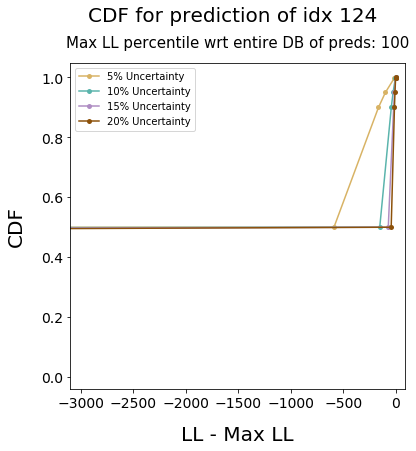

<Figure size 432x288 with 0 Axes>

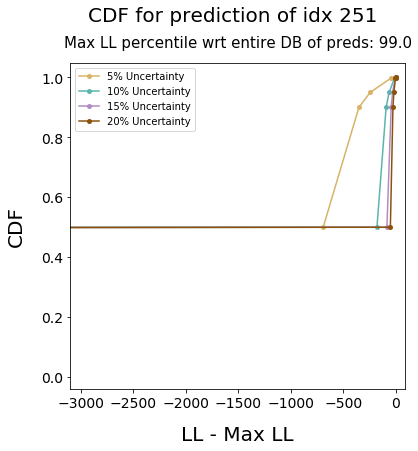

<Figure size 432x288 with 0 Axes>

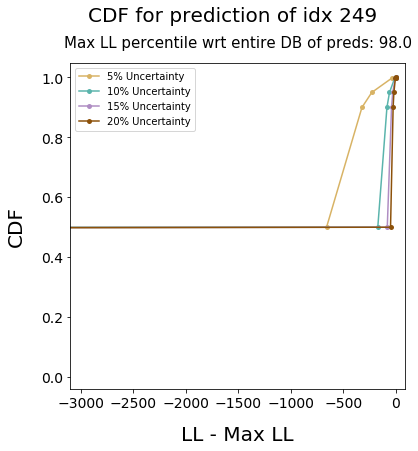

<Figure size 432x288 with 0 Axes>

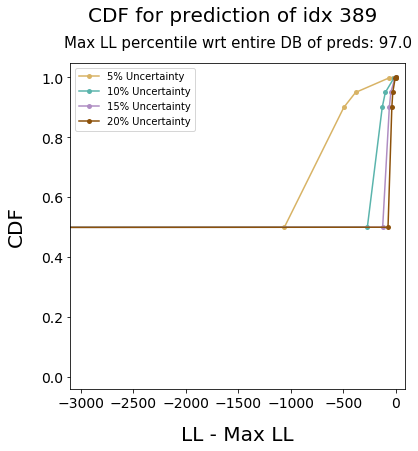

In [58]:
#plot_cdfs(23922, 'Tamu', 1)
#plot_cdfs(21141, 'Tamu', 0.99)
#plot_cdfs(23952, 'Tamu', 0.98)
#plot_cdfs(3428, 'Tamu', 0.97)
plot_cdfs(124, 'Sfco', 1)
plot_cdfs(251, 'Sfco', 0.99)
plot_cdfs(249, 'Sfco', 0.98)
plot_cdfs(389, 'Sfco', 0.97)

In [33]:
quants = [1, 0.99, 0.98, 0.97]
def percentile_idxs(quants, df):
    idxs = []
    for q in quants:
        max_ll_pred = df['MaxLogLL'].quantile(q, interpolation='higher')
        idxs.append(df.loc[df['MaxLogLL'] == max_ll_pred].index[0])
        print(max_ll_pred)
    print(idxs)
    return idxs
idxs_to_plot = percentile_idxs(quants, dfs['dfSfco0'])

-196.8738383596027
-215.61506387334381
-232.50068718920426
-249.22777262681
[124, 251, 249, 389]


In [87]:
df = dfs['dfSfco3']
maxLL = df['MaxLogLL'].max()#quantile(1, interpolation='higher')
df.loc[df['MaxLogLL'] == maxLL]

5.785697717525072

In [79]:
dfs.keys()

dict_keys(['dfTamu0', 'dfTamuRatio0', 'dfSfco0', 'dfTamu1', 'dfTamuRatio1', 'dfSfco1', 'dfTamu2', 'dfTamuRatio2', 'dfSfco2', 'dfTamu3', 'dfTamuRatio3', 'dfSfco3'])

In [128]:
sim_idx = 29
df = dfs['dfTamu0']
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
pred_lbls = ['pred_' + lbl for lbl in lbls]
lls = ['sim_idx', 'pred_idx', 'MaxLogLL', '2ndMaxLogLL']
df.loc[df.index == sim_idx, lls + lbls + pred_lbls]

,sim_idx,pred_idx,MaxLogLL,2ndMaxLogLL,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,pred_ReactorType,pred_CoolingTime,pred_Enrichment,pred_Burnup,pred_OrigenReactor
29,29,28,51.566745,48.69745,pwr,1.109213,0.53,8550.09,ce14x14,pwr,0.592485,0.53,8550.09,ce14x14
